#匯入有用封包、模組與函式

In [1]:
from google.colab import drive

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *

import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D, Reshape, Dropout
import random

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras import backend as K
import cv2

#GoogleDrive授權以便讀取檔案

In [2]:
# Google Drive授權，可直接讀取Drive內檔案
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
rootpath = '/content/gdrive/My Drive/Colab Notebooks/'

# 創建資料夾以儲存結果

if not os.path.exists(rootpath+'Result'):
  os.mkdir(rootpath+'Result')
  print('Create: ',rootpath+'Result')

if not os.path.exists(rootpath+'Result/Bad_Curves_TrainingData'):
  os.mkdir(rootpath+'Result/Bad_Curves_TrainingData')
  print('Create: ',rootpath+'Result/Bad_Curves_TrainingData')

if not os.path.exists(rootpath+'Result/Model'):
  os.mkdir(rootpath+'Result/Model')
  print('Create: ',rootpath+'Result/Model')

if not os.path.exists(rootpath+'Result/Plot'):
  os.mkdir(rootpath+'Result/Plot')
  print('Create: ',rootpath+'Result/Plot')

if not os.path.exists(rootpath+'Result/Test_Prediction'):
  os.mkdir(rootpath+'Result/Test_Prediction')
  print('Create: ',rootpath+'Result/Test_Prediction')

if not os.path.exists(rootpath+'Result/Test_Wrong_Cat'):
  os.mkdir(rootpath+'Result/Test_Wrong_Cat')
  print('Create: ',rootpath+'Result/Test_Wrong_Cat')

if not os.path.exists(rootpath+'Result/VisualizationHeatMap_TrainTest'):
  os.mkdir(rootpath+'Result/VisualizationHeatMap_TrainTest')
  print('Create: ',rootpath+'Result/VisualizationHeatMap_TrainTest')

if not os.path.exists(rootpath+'Result/VisualizationHeatMap_TrueTest'):
  os.mkdir(rootpath+'Result/VisualizationHeatMap_TrueTest')
  print('Create: ',rootpath+'Result/VisualizationHeatMap_TrueTest')

In [4]:
# 進入google drive資料夾
os.chdir(rootpath)

# 秀出當前路徑內檔案，確認是否在正確的路徑下
os.listdir()

['System dynamic HW',
 '20180903_Keras_HAR_WISDM_CNN_v1.0_for_medium.py',
 '2019_IMBD_ShuJiBao_Vis_1D_CNN(1).ipynb',
 'Untitled1.ipynb',
 'DAY001.ipynb',
 'DAY2.ipynb',
 'Day_001_HW.ipynb',
 'Day_002_HW.ipynb',
 'Day_003_HW(2).ipynb',
 'Day_004_first_EDA(1).ipynb',
 'Day_004_first_EDA.ipynb',
 'getdatafromdrive.ipynb',
 'Day_004_HW(2).ipynb',
 'Day_005-3_read_and_write_files.ipynb',
 'Day_005-2_HW(1).ipynb',
 'Day_005-2_HW.ipynb',
 'Day_005-1_build_dataframe_from_scratch(1).ipynb',
 'Day_005-1_build_dataframe_from_scratch.ipynb',
 'Day_005_HW(1).ipynb',
 'Day_005-2_read_and_write_files.ipynb',
 'Day_006_column_data_type.ipynb',
 'Day_005_HW.ipynb',
 'Day_003_HW(1).ipynb',
 'Day_003_HW.ipynb',
 'Day_004_HW(1).ipynb',
 'Day_004_HW.ipynb',
 'thubigdata2019exam-722.html',
 'thubigdata2019training-230.html',
 '“FBA - Week 03 - Python Practice.ipynb”的副本',
 'ML Project final.ipynb',
 'ML Project0116.ipynb',
 'Maze_Analysis_3A.ipynb',
 'testing-checkpoint.ipynb',
 '「TensorFlow with GPU」的副本',
 

#初賽訓練數據

##讀取並整理初賽訓練數據

In [5]:
# 初賽訓練數據資料夾內子資料夾
ClassFolder = os.listdir(rootpath+'thubigdata2019training-230/大數據競賽初賽資料(230測試數據)')
print(ClassFolder)

['G15', 'G11', 'G32', 'G34', 'G17', 'G49', 'G19', 'G48']


In [6]:
# 利用迴圈將所有資料夾內檔案整合成一個dataframe
init_cnt = 0

for i in range(0,len(ClassFolder)):
  # 進入不同子資料夾以讀取檔案
  os.chdir(rootpath+'thubigdata2019training-230/大數據競賽初賽資料(230測試數據)/'+ClassFolder[i])
  FileName_tmp = os.listdir()

  for j in range(0,len(FileName_tmp)):
    data_tmp = pd.read_csv(FileName_tmp[j], sep='\\t', engine='python')
    data_tmp = data_tmp.transpose()
    data_tmp = data_tmp.drop([0],axis=1) #丟掉溫度單位(Deg.F)
    data_tmp = data_tmp.astype(float) #將string轉換成float
    data_tmp.insert(0,'Type',FileName_tmp[j][0:3])
    data_tmp.insert(0,'FileName', FileName_tmp[j])
    if init_cnt == 0:
      data = data_tmp
      init_cnt += 1
    else:
      data = pd.concat([data, data_tmp], ignore_index=True, sort=False)

data = data.reset_index()
data = data.rename(columns={"index":"Col"})

print(data.head())
print(data.shape)

   Col                              FileName Type     1     2     3     4  \
0    0  G15 -AC(7X15)20160707-003_Export.txt  G15  81.2  81.2  81.2  81.2   
1    1  G15 -AC(7X15)20160707-003_Export.txt  G15  81.6  81.6  81.6  81.6   
2    2  G15 -AC(7X15)20160707-003_Export.txt  G15  81.3  81.3  81.3  81.3   
3    3  G15 -AC(7X15)20160707-003_Export.txt  G15  80.0  80.0  80.0  80.0   
4    4  G15 -AC(7X15)20160707-003_Export.txt  G15  80.8  80.8  80.8  80.8   

      5     6     7  ...  440  441  442  443  444  445  446  447  448  449  
0  81.4  82.0  83.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1  82.4  83.8  85.1  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2  81.7  82.9  84.5  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3  80.4  81.2  82.5  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4  81.5  82.7  84.2  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 452 columns]
(1745, 452)


##初賽訓練數據的設置分配與前處理

###對時間溫度曲線數據進行微分

In [7]:
m, n = data.shape
x_tmp1 = data.iloc[:,3:n].values.copy()
x_tmp2 = data.iloc[:,3:n].values.copy()
data_diff = data.copy()

for i in range(0,m):
  f = x_tmp1[i,0:n]

  ind = np.isnan(f)
  f[np.isnan(f)] = f[f.shape[0]-ind.sum()-1]

  fg = np.gradient(f)

  x_tmp1[i,0:n] = f
  x_tmp2[i,0:n] = fg

data.iloc[:,3:n] = x_tmp1
data_diff.iloc[:,3:n] = x_tmp2

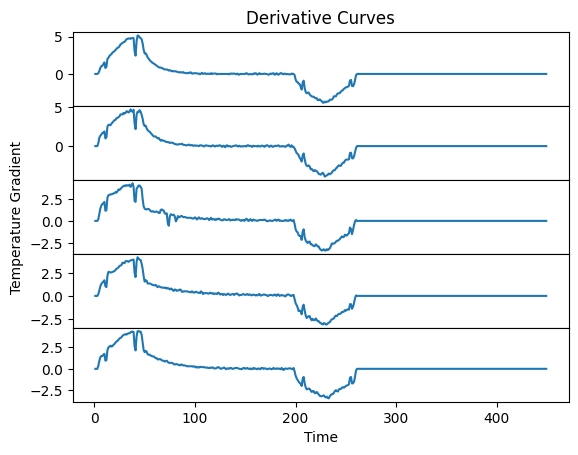

In [8]:
# 畫出train前5個微分的時間溫度曲線
subplots_adjust(hspace=0.000)
number_of_subplots=5

for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = subplot(number_of_subplots,1,v)
    ax1.plot(data_diff.iloc[i,3:n])

    if i == 0:
      plt.title('Derivative Curves')
    elif i == round(number_of_subplots/2):
      plt.ylabel('Temperature Gradient')
    elif i == number_of_subplots-1:
      plt.xlabel('Time')

plt.show()

figure=ax1.get_figure()
output_file = rootpath+'Result/Plot/derivative_curves.jpg'
figure.savefig(output_file)

###將不穩定的時間溫度曲線剔除，以免影響模型表現。

In [9]:
# 對微分數值設閾值，篩選不穩定之時間溫度曲線
ind_bad = []
m, n = data_diff.shape

for i in range(0,m):
  tmp = data_diff.iloc[i,3:n].values.copy()

  if abs(tmp.min())>15 or abs(tmp.max())>15:
    ind_bad = ind_bad + [i]

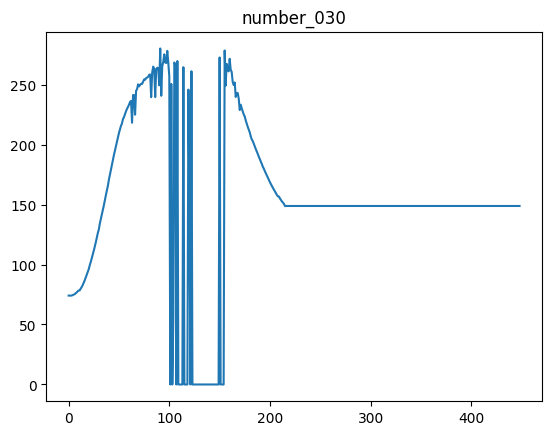

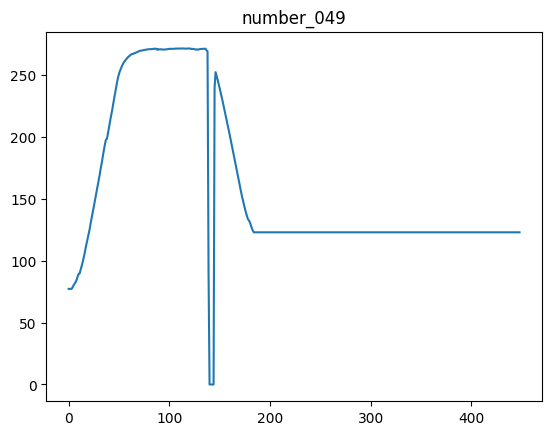

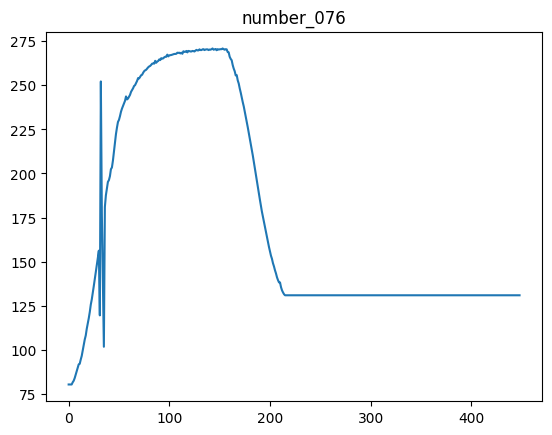

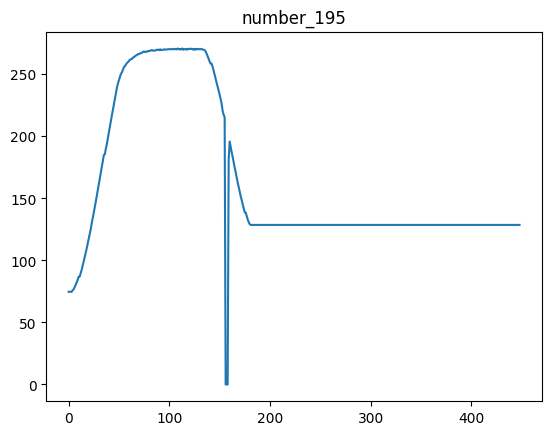

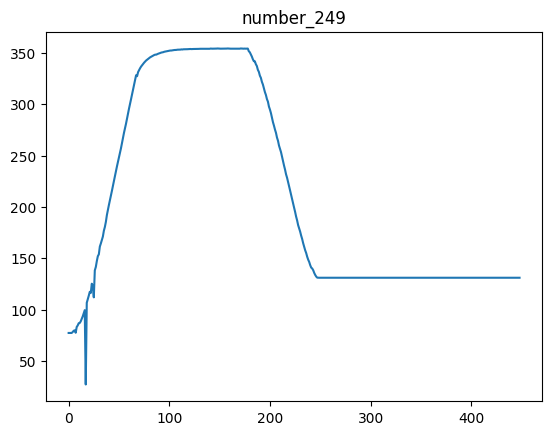

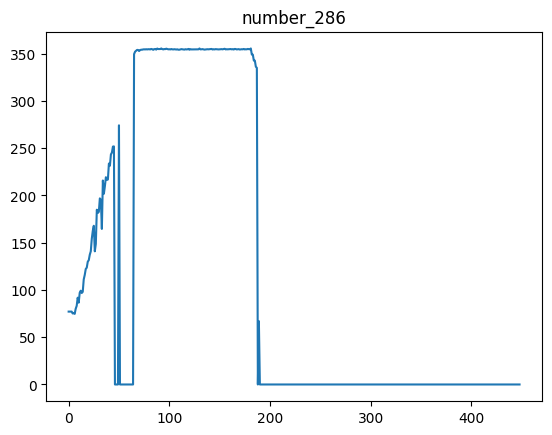

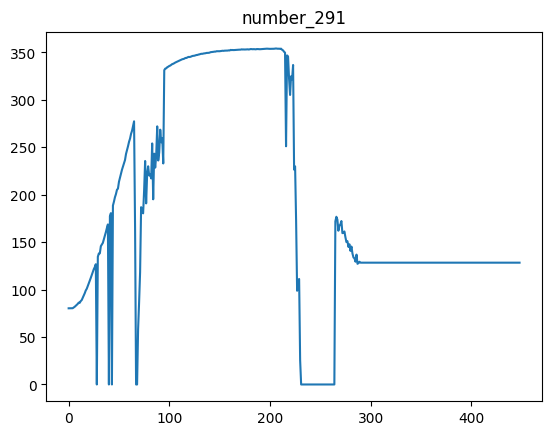

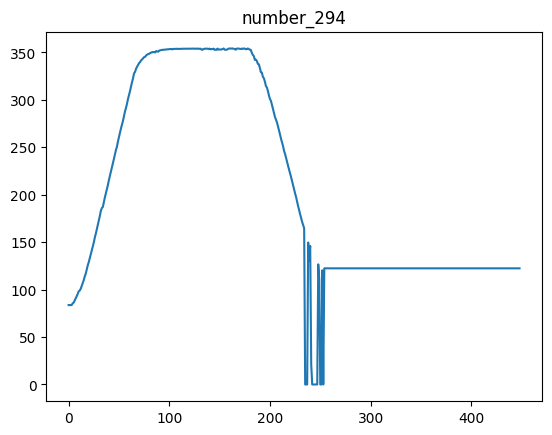

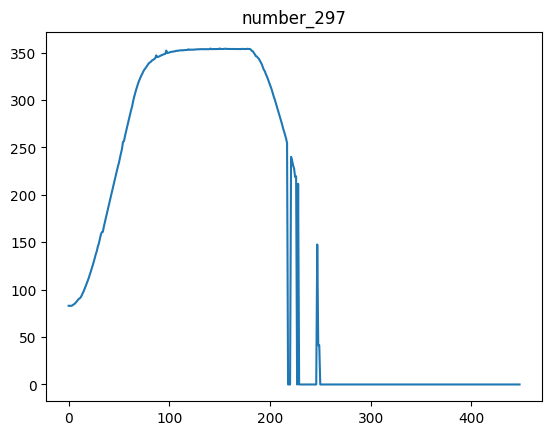

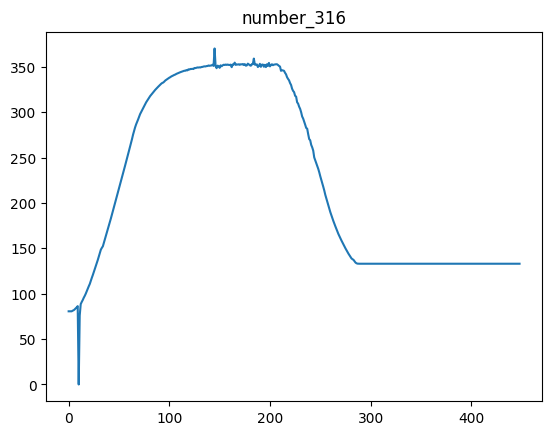

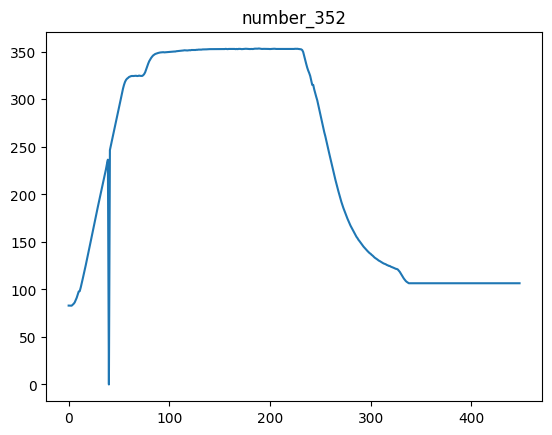

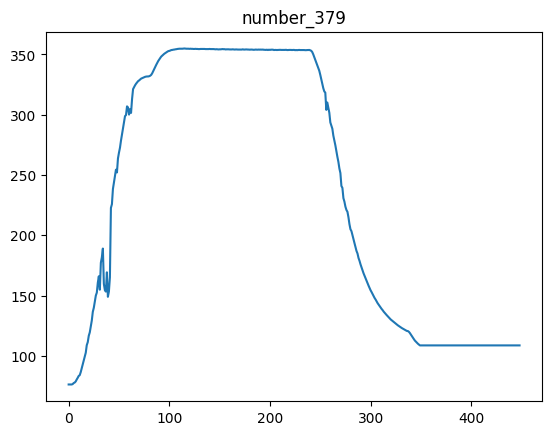

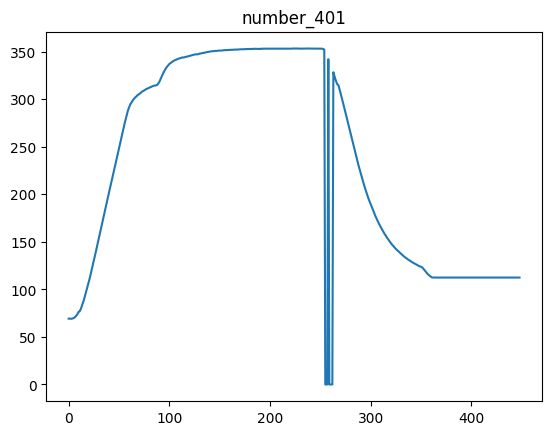

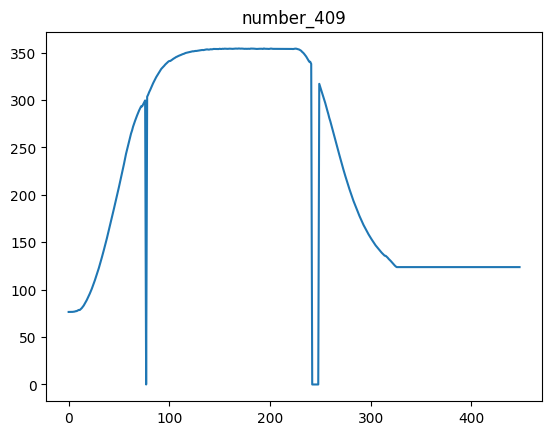

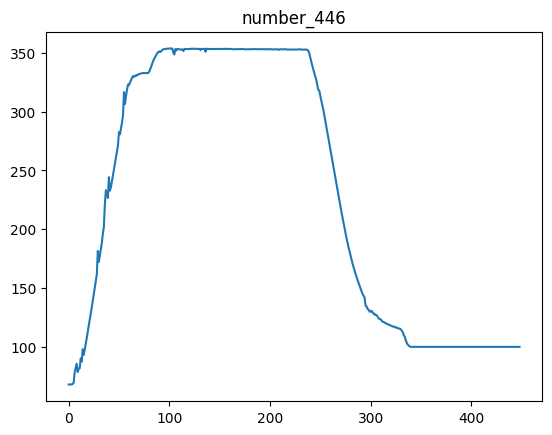

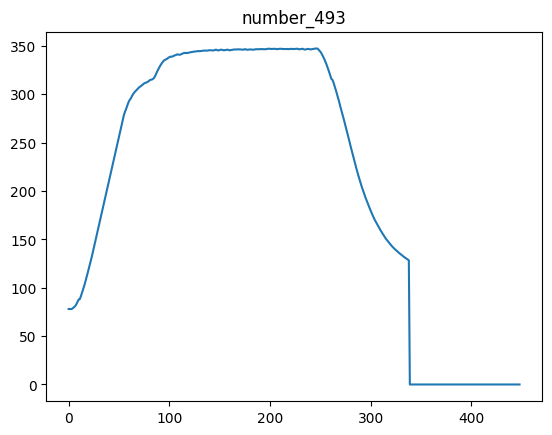

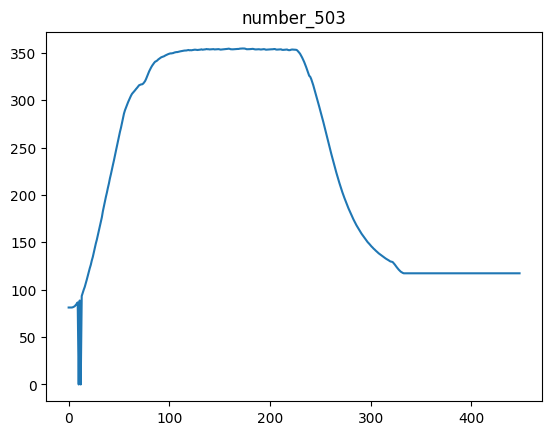

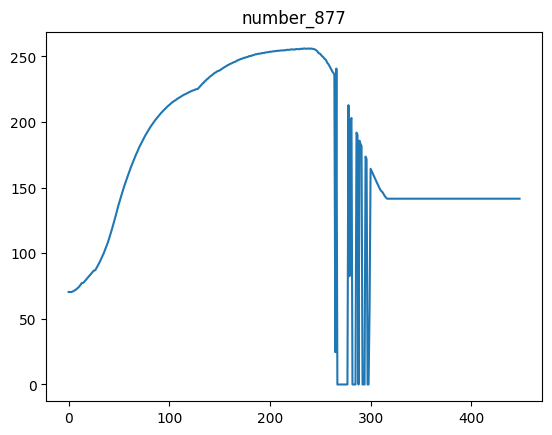

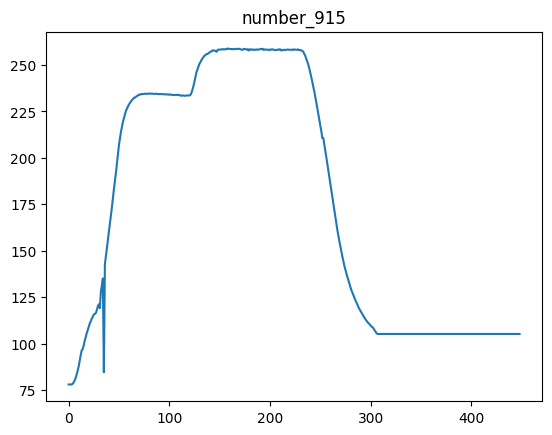

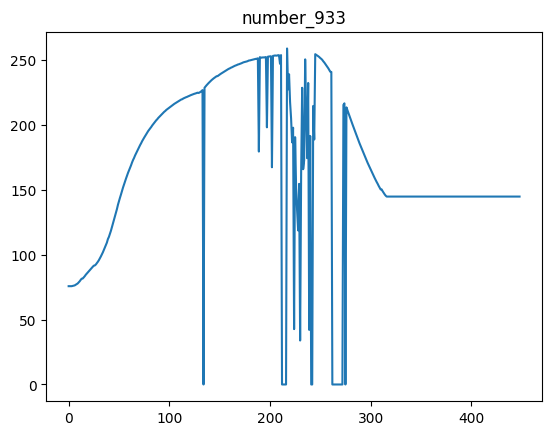

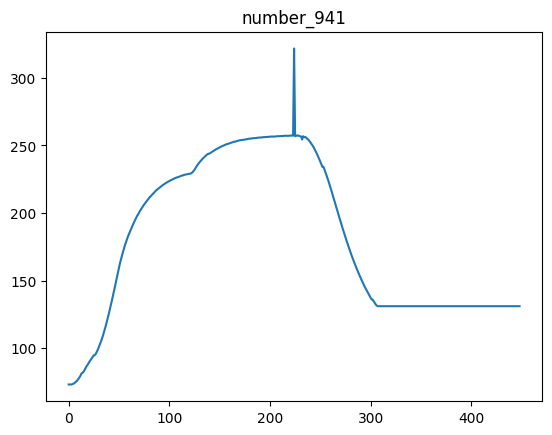

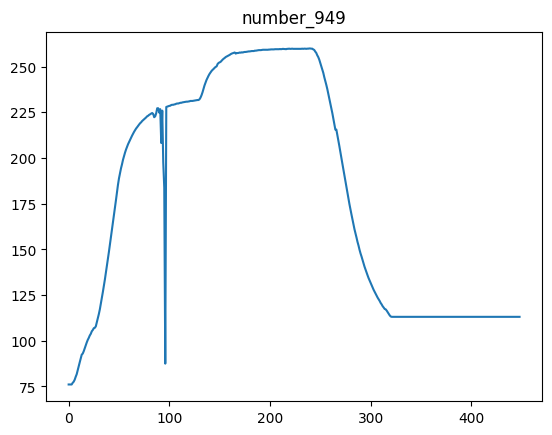

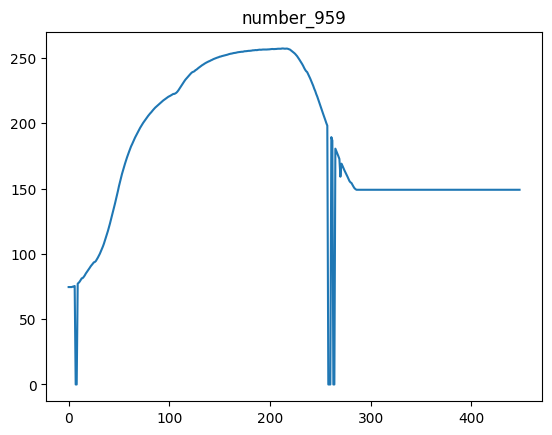

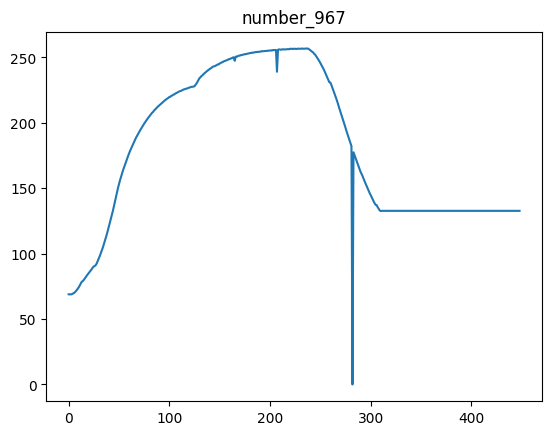

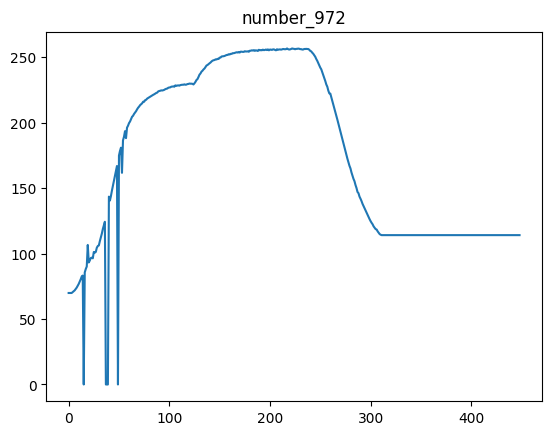

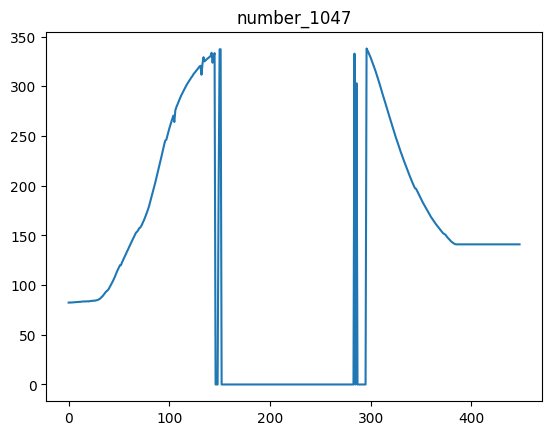

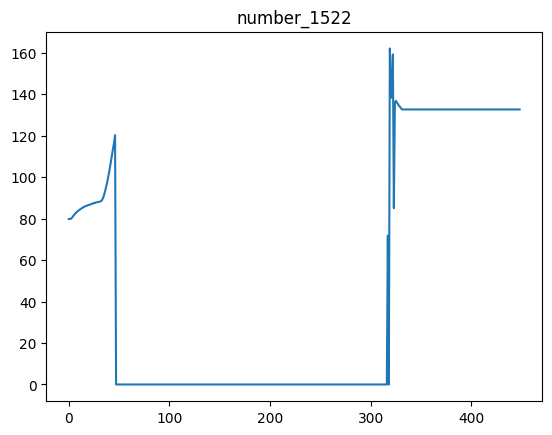

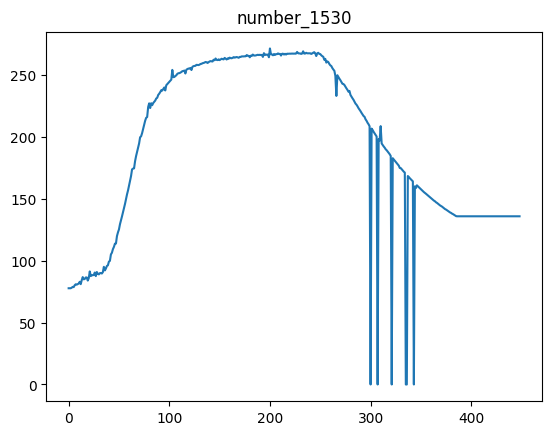

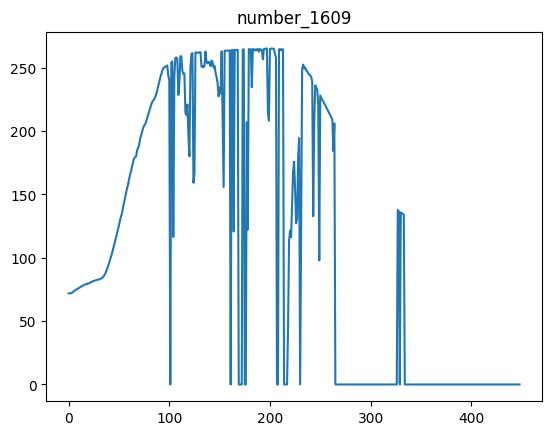

In [10]:
# 繪製不穩定之時間溫度曲線
m, n = data.shape

for i in ind_bad:
  str_1 = str(i).zfill(3);

  plt.plot(data.iloc[i,3:n].values)
  plt.title('number_'+str_1)
  output_file = rootpath+'Result/Bad_Curves_TrainingData/'+str_1+'.jpg'
  plt.savefig(output_file)

  plt.figure
  plt.show()

In [11]:
# 將品質壞掉的時間溫度曲線拿掉
data_fin = data.drop(data.index[ind_bad])
data_diff_fin = data_diff.drop(data_diff.index[ind_bad])

print('Original shape:',data.shape)
print('Final shape:',data_fin.shape)

Original shape: (1745, 452)
Final shape: (1716, 452)


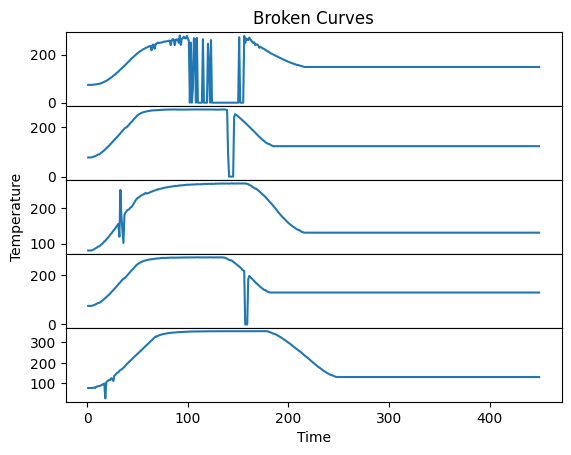

In [12]:
# 畫出前5個壞掉的時間溫度曲線
subplots_adjust(hspace=0.000)
number_of_subplots=5

for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = subplot(number_of_subplots,1,v)
    ax1.plot(data.iloc[ind_bad[i],3:data.shape[1]])

    if i == 0:
      plt.title('Broken Curves')
    elif i == round(number_of_subplots/2):
      plt.ylabel('Temperature')
    elif i == number_of_subplots-1:
      plt.xlabel('Time')

plt.show()

figure=ax1.get_figure()
output_file = rootpath+'Result/Plot/broken_curves.jpg'
figure.savefig(output_file)

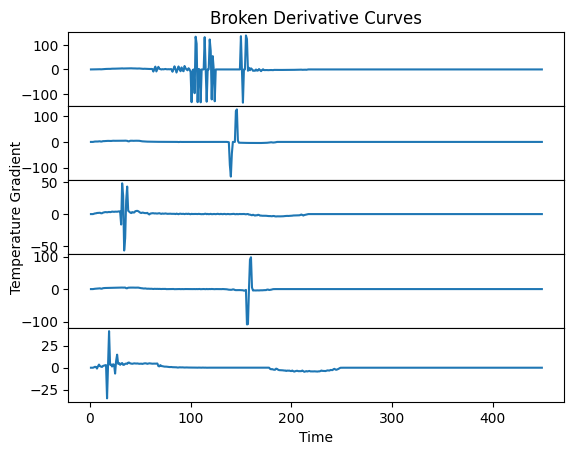

In [13]:
# 畫出前5個壞掉的時間溫度曲線
subplots_adjust(hspace=0.000)
number_of_subplots=5

for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = subplot(number_of_subplots,1,v)
    ax1.plot(data_diff.iloc[ind_bad[i],3:data.shape[1]])

    if i == 0:
      plt.title('Broken Derivative Curves')
    elif i == round(number_of_subplots/2):
      plt.ylabel('Temperature Gradient')
    elif i == number_of_subplots-1:
      plt.xlabel('Time')

plt.show()

figure=ax1.get_figure()
output_file = rootpath+'Result/Plot/broken_derivative_curves.jpg'
figure.savefig(output_file)

###將初賽訓練數據分配成90%訓練與10%測試，以評估模型。

In [14]:
# 隨機分配數據為90%訓練和10%測試
fun_1 = lambda x: x.sample(frac=0.9, replace=False, random_state=1)

data_fin_Train = data_diff_fin.groupby('Type', group_keys=False).apply(fun_1)
data_fin_Test = data_diff_fin.drop(data_fin_Train.index)

print('Train shape:',data_fin_Train.shape)
print('Test shape:',data_fin_Test.shape)

Train shape: (1545, 452)
Test shape: (171, 452)


<ipython-input-14-970224b30cb3>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_fin_Train = data_diff_fin.groupby('Type', group_keys=False).apply(fun_1)


In [15]:
# 檢查在Train和Test資料分布比例是否一致
type_counts_Train = data_fin_Train.groupby('Type', group_keys=False).count()
type_counts_Train = type_counts_Train['Col']
type_counts_Train = type_counts_Train/type_counts_Train.sum()*100
type_counts_Train.index.name = "Type (%)"

type_counts_Test = data_fin_Test.groupby('Type', group_keys=False).count()
type_counts_Test = type_counts_Test['Col']
type_counts_Test = type_counts_Test/type_counts_Test.sum()*100
type_counts_Test.index.name = "Type (%)"

print('Train: ',type_counts_Train)
print('Test: ',type_counts_Test)

Train:  Type (%)
G11     8.090615
G15    11.844660
G17     6.472492
G19    13.851133
G32    14.498382
G34    15.404531
G48    14.045307
G49    15.792880
Name: Col, dtype: float64
Test:  Type (%)
G11     8.187135
G15    11.695906
G17     6.432749
G19    14.035088
G32    14.619883
G34    15.204678
G48    14.035088
G49    15.789474
Name: Col, dtype: float64


In [16]:
# 設置x和y
x_all_train = data_fin_Train.drop(['Col','FileName','Type'],axis=1)
x_all_test = data_fin_Test.drop(['Col','FileName','Type'],axis=1)

# 將y做成one-hot encoding
# 要注意不同模型訓練的時候丟入的y有可能是原本0和1(y_train)，或是經過one-hot encoding的(y_dummy)
y_all_train = data_fin_Train['Type']
y_all_dummy_train = pd.get_dummies(y_all_train)
y_all_test = data_fin_Test['Type']
y_all_dummy_test = pd.get_dummies(y_all_test)


In [17]:
# 檢視設置結果
print('train:')
print('x:',x_all_train.shape)
print(x_all_train.head(3))
print('y:',y_all_dummy_train.shape)
print(y_all_dummy_train.head(3))
print()
print('test:')
print('x:',x_all_test.shape)
print(x_all_test.head(3))
print('y:',y_all_dummy_test.shape)
print(y_all_dummy_test.head(3))

train:
x: (1545, 449)
     1    2    3     4     5     6     7     8     9     10   ...  440  441  \
273  0.0  0.0  0.0  1.00  1.30  1.00  1.55  1.95  2.15  2.15  ...  0.0  0.0   
266  0.0  0.0  0.0  0.10  0.35  0.60  0.75  0.90  1.20  1.30  ...  0.0  0.0   
250  0.0  0.0  0.0  0.35  0.85  0.75  0.75  1.25  1.55  1.50  ...  0.0  0.0   

     442  443  444  445  446  447  448  449  
273  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
266  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
250  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 449 columns]
y: (1545, 8)
      G11    G15    G17    G19    G32    G34    G48    G49
273  True  False  False  False  False  False  False  False
266  True  False  False  False  False  False  False  False
250  True  False  False  False  False  False  False  False

test:
x: (171, 449)
    1    2    3     4     5     6     7     8     9     10   ...  440  441  \
20  0.0  0.0  0.0  0.25  0.50  0.45  0.60  1.00  1.25  1.15  ...  0.0  0.0   
25  0.0  0.0  0.0  0.55  0.

##訓練模型建構

In [18]:
# 在您的代码中添加以下代码：
import keras
import tensorflow

print("Keras version:", keras.__version__)
print("TensorFlow version:", tensorflow.__version__)

Keras version: 3.8.0
TensorFlow version: 2.18.0


In [19]:
# 建構訓練模型函式以便單獨與cross-validation使用

def evaluate_model(X_train, y_train, save_model_str, *args):

  # 建構1D-CNN的模型
  model = Sequential()
  # 將模型reshape成(時間長度,1)，每筆輸入的曲線為(時間長度,)的大小
  model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))
  model.add(Conv1D(100, 10, activation='relu', input_shape=(X_train.shape[1], 1)))
  model.add(Conv1D(100, 10, activation='relu'))
  model.add(MaxPooling1D(3))
  model.add(Conv1D(160, 10, activation='relu'))
  model.add(Conv1D(160, 10, activation='relu'))
  model.add(GlobalAveragePooling1D())
  #model.add(Dropout(0.5))
  model.add(Dense(y_train.shape[1], activation='softmax'))

  # compile此模型以便開始訓練
  model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

  if save_model_str == 'model_CV.weights.h5':
    X_val = args[0]
    y_val = args[1]

    # 進入結果資料夾
    os.chdir(rootpath+'Result/Model')
    model.save_weights(save_model_str) #儲存未訓練參數，以便cross-validation重新訓練時重置

    random.seed (21)
    history = model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=50, batch_size=100, verbose=2)

    _, val_acc = model.evaluate(X_val, y_val, verbose = 1)
    model.load_weights(save_model_str) #讀取未訓練參數，以便cross-validation重新訓練時重置


  else:
    random.seed (21)
    history = model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=2)



    # 進入結果資料夾
    os.chdir(rootpath+'Result/Model')
    model.save_weights(save_model_str) #將訓練好的模型儲存

    _, val_acc = model.evaluate(X_train, y_train, verbose = 1)

  return model, val_acc, history

###5-fold交叉驗證訓練評估模型穩定度

In [20]:
# 開始進行cross-validation

n_folds = 5
cv_scores, model_history, train_history = list(), list(), list()

for _ in range(n_folds):
  # split data
  X_train, X_val, y_train, y_val = \
      train_test_split(x_all_train, y_all_dummy_train, test_size=1/n_folds, \
      random_state = np.random.randint(1,1000, 1)[0], stratify=y_all_dummy_train)

  # evaluate model
  model, val_acc, history = evaluate_model(X_train, y_train, 'model_CV.weights.h5', X_val, y_val)
  print('>%.3f' % val_acc)

  cv_scores.append(val_acc)
  model_history.append(model)
  train_history.append(history)


  print("train_history length:", len(train_history))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
13/13 - 13s - 993ms/step - accuracy: 0.1756 - loss: 1.9655 - val_accuracy: 0.1618 - val_loss: 1.7731
Epoch 2/50
13/13 - 0s - 28ms/step - accuracy: 0.4377 - loss: 1.4102 - val_accuracy: 0.6667 - val_loss: 0.9228
Epoch 3/50
13/13 - 0s - 31ms/step - accuracy: 0.7710 - loss: 0.5999 - val_accuracy: 0.8900 - val_loss: 0.3533
Epoch 4/50
13/13 - 0s - 28ms/step - accuracy: 0.8997 - loss: 0.2873 - val_accuracy: 0.9417 - val_loss: 0.2059
Epoch 5/50
13/13 - 0s - 28ms/step - accuracy: 0.9304 - loss: 0.1797 - val_accuracy: 0.9547 - val_loss: 0.1114
Epoch 6/50
13/13 - 0s - 28ms/step - accuracy: 0.9587 - loss: 0.1105 - val_accuracy: 0.9838 - val_loss: 0.1028
Epoch 7/50
13/13 - 1s - 49ms/step - accuracy: 0.9660 - loss: 0.1119 - val_accuracy: 0.9903 - val_loss: 0.0437
Epoch 8/50
13/13 - 0s - 28ms/step - accuracy: 0.9676 - loss: 0.0890 - val_accuracy: 0.9773 - val_loss: 0.0617
Epoch 9/50
13/13 - 0s - 28ms/step - accuracy: 0.9717 - loss: 0.0807 - val_accuracy: 0.9709 - val_loss: 0.0709
Epoch 10

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 - 5s - 393ms/step - accuracy: 0.2039 - loss: 1.8539 - val_accuracy: 0.3819 - val_loss: 1.4952
Epoch 2/50
13/13 - 2s - 152ms/step - accuracy: 0.6408 - loss: 1.0139 - val_accuracy: 0.7767 - val_loss: 0.6725
Epoch 3/50
13/13 - 0s - 38ms/step - accuracy: 0.8018 - loss: 0.5554 - val_accuracy: 0.8932 - val_loss: 0.4085
Epoch 4/50
13/13 - 1s - 49ms/step - accuracy: 0.9142 - loss: 0.2812 - val_accuracy: 0.9612 - val_loss: 0.1565
Epoch 5/50
13/13 - 1s - 48ms/step - accuracy: 0.9571 - loss: 0.1407 - val_accuracy: 0.9871 - val_loss: 0.0782
Epoch 6/50
13/13 - 1s - 46ms/step - accuracy: 0.9806 - loss: 0.0703 - val_accuracy: 0.9741 - val_loss: 0.0646
Epoch 7/50
13/13 - 0s - 30ms/step - accuracy: 0.9854 - loss: 0.0520 - val_accuracy: 0.9709 - val_loss: 0.0778
Epoch 8/50
13/13 - 1s - 47ms/step - accuracy: 0.9814 - loss: 0.0673 - val_accuracy: 0.9579 - val_loss: 0.0884
Epoch 9/50
13/13 - 0s - 29ms/step - accuracy: 0.9668 - loss: 0.0902 - val_accuracy: 0.9223 - val_loss: 0.2349
Epoch 10/50
13/13 -

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>1.000
train_history length: 2
Epoch 1/50
13/13 - 5s - 414ms/step - accuracy: 0.1942 - loss: 1.8569 - val_accuracy: 0.4498 - val_loss: 1.4953
Epoch 2/50
13/13 - 1s - 41ms/step - accuracy: 0.5793 - loss: 1.1207 - val_accuracy: 0.5825 - val_loss: 0.9338
Epoch 3/50
13/13 - 0s - 30ms/step - accuracy: 0.7557 - loss: 0.6118 - val_accuracy: 0.8350 - val_loss: 0.4295
Epoch 4/50
13/13 - 0s - 30ms/step - accuracy: 0.8592 - loss: 0.3707 - val_accuracy: 0.9223 - val_loss: 0.2852
Epoch 5/50
13/13 - 1s - 48ms/step - accuracy: 0.9401 - loss: 0.1943 - val_accuracy: 0.9644 - val_loss: 0.1142
Epoch 6/50
13/13 - 0s - 31ms/step - accuracy: 0.9652 - loss: 0.1098 - val_accuracy: 0.9741 - val_loss: 0.0700
Epoch 7/50
13/13 - 1s - 47ms/step - accuracy: 0.9782 - loss: 0.0626 - val_accuracy: 0.9644 - val_loss: 0.0926
Epoch 8/50
13/13 - 0s - 30ms/step - accuracy: 0.9814 - loss: 0.0597 - val_accuracy: 0.9773 - val_loss: 0.0578
Epoch 9/50
13/13 - 0s - 30ms/step - accuracy: 0.9838 - loss: 0.0575 - val_accuracy: 0.98

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 - 6s - 448ms/step - accuracy: 0.2144 - loss: 1.8389 - val_accuracy: 0.5631 - val_loss: 1.4082
Epoch 2/50
13/13 - 1s - 96ms/step - accuracy: 0.6019 - loss: 1.0751 - val_accuracy: 0.6926 - val_loss: 0.7274
Epoch 3/50
13/13 - 1s - 42ms/step - accuracy: 0.7508 - loss: 0.5962 - val_accuracy: 0.8511 - val_loss: 0.4444
Epoch 4/50
13/13 - 1s - 46ms/step - accuracy: 0.8746 - loss: 0.3194 - val_accuracy: 0.9320 - val_loss: 0.2079
Epoch 5/50
13/13 - 1s - 46ms/step - accuracy: 0.9345 - loss: 0.1891 - val_accuracy: 0.9644 - val_loss: 0.1302
Epoch 6/50
13/13 - 0s - 31ms/step - accuracy: 0.9547 - loss: 0.1384 - val_accuracy: 0.9709 - val_loss: 0.0806
Epoch 7/50
13/13 - 1s - 49ms/step - accuracy: 0.9709 - loss: 0.0857 - val_accuracy: 0.9871 - val_loss: 0.0527
Epoch 8/50
13/13 - 0s - 30ms/step - accuracy: 0.9790 - loss: 0.0617 - val_accuracy: 0.9871 - val_loss: 0.0422
Epoch 9/50
13/13 - 0s - 30ms/step - accuracy: 0.9765 - loss: 0.0744 - val_accuracy: 0.9806 - val_loss: 0.0478
Epoch 10/50
13/13 - 

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 - 5s - 411ms/step - accuracy: 0.1756 - loss: 1.8513 - val_accuracy: 0.4563 - val_loss: 1.5238
Epoch 2/50
13/13 - 2s - 131ms/step - accuracy: 0.5769 - loss: 1.0828 - val_accuracy: 0.6052 - val_loss: 0.7739
Epoch 3/50
13/13 - 1s - 39ms/step - accuracy: 0.7791 - loss: 0.5816 - val_accuracy: 0.9223 - val_loss: 0.3276
Epoch 4/50
13/13 - 0s - 29ms/step - accuracy: 0.9037 - loss: 0.2905 - val_accuracy: 0.9288 - val_loss: 0.1839
Epoch 5/50
13/13 - 1s - 51ms/step - accuracy: 0.9248 - loss: 0.1987 - val_accuracy: 0.9256 - val_loss: 0.2351
Epoch 6/50
13/13 - 0s - 33ms/step - accuracy: 0.9515 - loss: 0.1503 - val_accuracy: 0.9806 - val_loss: 0.0710
Epoch 7/50
13/13 - 0s - 34ms/step - accuracy: 0.9806 - loss: 0.0714 - val_accuracy: 0.9773 - val_loss: 0.0749
Epoch 8/50
13/13 - 0s - 33ms/step - accuracy: 0.9806 - loss: 0.0633 - val_accuracy: 0.9838 - val_loss: 0.0713
Epoch 9/50
13/13 - 1s - 48ms/step - accuracy: 0.9838 - loss: 0.0526 - val_accuracy: 0.9838 - val_loss: 0.0501
Epoch 10/50
13/13 -

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [21]:
#交叉驗證準確度的平均(標準差)
print(cv_scores)
print('Estimated Accuracy %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

[0.9935275316238403, 1.0, 0.9967637658119202, 1.0, 1.0]
Estimated Accuracy 0.998 (0.003)


###檢視交叉驗證訓練過程

In [22]:
def show_train_history(train_history,train,validation):
  subplots_adjust(hspace=0.000)
  number_of_subplots=len(train_history)

  for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = subplot(number_of_subplots,1,v)
    ax1.plot(train_history[i].history[train])
    ax1.plot(train_history[i].history[validation])

    if i == 0:
      plt.title('Train History')
    elif i == round(number_of_subplots/2):
      plt.ylabel(train)
    elif i == number_of_subplots-1:
      plt.xlabel('Epoch')
      plt.legend(['train', 'validation'], loc='upper right')

  plt.show()

  figure=ax1.get_figure()
  output_file = rootpath+'Result/Plot/cv_training_history_'+train+'.jpg'
  figure.savefig(output_file)

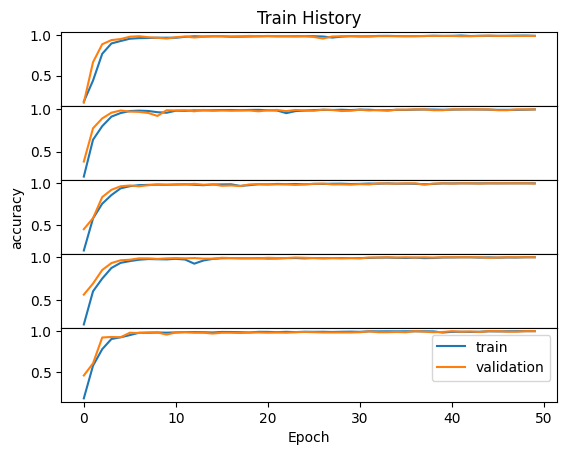

In [23]:
# 準確度
show_train_history(train_history,'accuracy','val_accuracy')

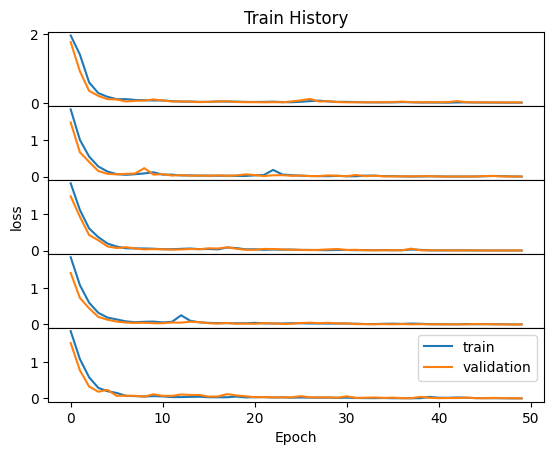

In [24]:
# Loss
show_train_history(train_history,'loss','val_loss')

###使用所有90%訓練數據建構模型

In [25]:
# 訓練90%訓練數據，建構模型
model, val_acc, history = evaluate_model(x_all_train, y_all_dummy_train, 'model_CV_fin.weights.h5')
print('>%.3f' % val_acc)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 - 7s - 454ms/step - accuracy: 0.1981 - loss: 1.7712
Epoch 2/50
16/16 - 5s - 340ms/step - accuracy: 0.6485 - loss: 0.9280
Epoch 3/50
16/16 - 1s - 33ms/step - accuracy: 0.8725 - loss: 0.3601
Epoch 4/50
16/16 - 1s - 38ms/step - accuracy: 0.9372 - loss: 0.1896
Epoch 5/50
16/16 - 1s - 38ms/step - accuracy: 0.9586 - loss: 0.1315
Epoch 6/50
16/16 - 1s - 39ms/step - accuracy: 0.9761 - loss: 0.0851
Epoch 7/50
16/16 - 1s - 39ms/step - accuracy: 0.9819 - loss: 0.0530
Epoch 8/50
16/16 - 1s - 38ms/step - accuracy: 0.9877 - loss: 0.0390
Epoch 9/50
16/16 - 1s - 39ms/step - accuracy: 0.9825 - loss: 0.0500
Epoch 10/50
16/16 - 1s - 39ms/step - accuracy: 0.9741 - loss: 0.0641
Epoch 11/50
16/16 - 0s - 26ms/step - accuracy: 0.9398 - loss: 0.2016
Epoch 12/50
16/16 - 0s - 26ms/step - accuracy: 0.9832 - loss: 0.0596
Epoch 13/50
16/16 - 1s - 38ms/step - accuracy: 0.9877 - loss: 0.0393
Epoch 14/50
16/16 - 1s - 39ms/step - accuracy: 0.9858 - loss: 0.0347
Epoch 15/50
16/16 - 0s - 26ms/step - accuracy: 0.989

In [26]:
# 預測訓練模型並檢視結果
y_probs_train = model.predict(x_all_train) #利用訓練後模型預測train資料的結果
print(y_probs_train.shape) #矩陣大小
print(y_probs_train[0:4,:]) #只顯示前五列

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
(1545, 8)
[[9.9998295e-01 1.6109856e-05 4.6202743e-07 1.0690796e-21 4.3184960e-07
  9.1030449e-22 6.3282685e-14 3.0654229e-12]
 [9.9926180e-01 1.2647978e-08 1.0273648e-06 1.1034641e-24 7.3712599e-04
  1.7029710e-20 9.0745016e-12 6.7363404e-10]
 [9.9899727e-01 9.9481503e-04 7.9163592e-06 8.2469545e-23 1.6000502e-07
  9.0936168e-23 1.9181939e-12 1.2273654e-12]
 [9.9999905e-01 2.1752676e-08 2.0365928e-07 1.0940677e-25 6.9400073e-07
  8.2929774e-22 9.3886324e-14 1.8111825e-11]]


In [27]:
# 數字轉換分類結果
ind = np.argmax(y_probs_train,1)
y_prdict = data_fin.Type.astype('category')
y_prdict = y_prdict.dtypes.categories
y_prdict = y_prdict[ind]
y_prdict = pd.Series(y_prdict)

# 訓練與驗證數據，訓練準確度
accuracy = accuracy_score(y_all_train, y_prdict)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


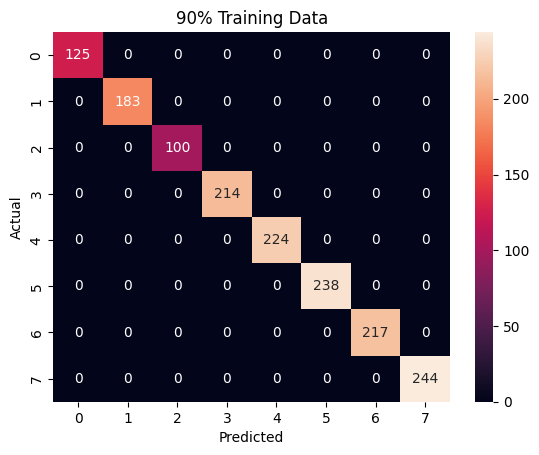

In [28]:
# 畫出confusion matrix
cm = confusion_matrix(y_all_train,y_prdict)
ax = sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual', title='90% Training Data')
np.shape(y_all_train)

figure = ax.get_figure()
output_file = rootpath+'Result/Plot/train_confusion_matrix.jpg'
figure.savefig(output_file)

###10%測試數據的預測與評估

In [29]:
y_probs_test = model.predict(x_all_test)
print(y_probs_test.shape) #矩陣大小
print(y_probs_test[0:4,:]) #只顯示前五列

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
(171, 8)
[[9.0084017e-05 9.9664021e-01 7.1515897e-06 3.0492402e-03 2.1329445e-04
  1.7895037e-16 5.3206360e-13 1.9424259e-11]
 [9.6670301e-05 9.9152291e-01 3.8774024e-06 8.2436511e-03 1.3290012e-04
  4.7808107e-16 1.2688510e-13 2.5255520e-11]
 [5.3019980e-05 9.9994397e-01 4.2182373e-09 3.0346441e-06 1.8467407e-10
  6.2901690e-20 5.5351137e-19 3.3102719e-15]
 [1.5626605e-04 9.9984324e-01 2.9218637e-07 8.0310116e-08 2.1733913e-11
  7.6552658e-20 1.1423230e-15 5.6572204e-15]]


In [30]:
# 數字轉換分類結果
ind = np.argmax(y_probs_test,1)
y_prdict_test = data_fin.Type.astype('category')
y_prdict_test = y_prdict_test.dtypes.categories
y_prdict_test = y_prdict_test[ind]
y_prdict_test = pd.Series(y_prdict_test)

# 測試數據，預測準確度
# evaluate predictions
accuracy = accuracy_score(y_all_test, y_prdict_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


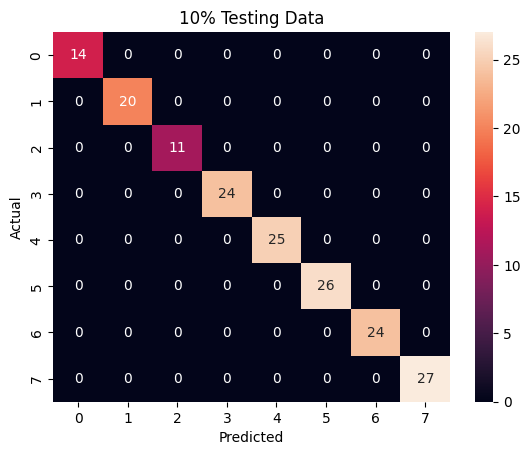

In [31]:
# 畫出confusion matrix
cm = confusion_matrix(y_all_test,y_prdict_test)
ax = sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual', title='10% Testing Data')
np.shape(y_all_test)

figure = ax.get_figure()
output_file = rootpath+'Result/Plot/test_confusion_matrix.jpg'
figure.savefig(output_file)

###將所有初賽訓練數據加入進行最終模型建構

In [39]:
# 將訓練與測試數據結合
x_all = np.append(x_all_train,x_all_test,axis=0)
y_dummy_all = np.append(y_all_dummy_train,y_all_dummy_test,axis=0)

In [42]:
# 訓練全部的初賽訓練數據，建構最後模型
model, val_acc, history = evaluate_model(x_all, y_dummy_all, 'model_fin.weights.h5')
print('>%.3f' % val_acc)

Epoch 1/50
18/18 - 8s - 422ms/step - accuracy: 0.2587 - loss: 1.7006
Epoch 2/50
18/18 - 0s - 26ms/step - accuracy: 0.7314 - loss: 0.7437
Epoch 3/50
18/18 - 0s - 25ms/step - accuracy: 0.8899 - loss: 0.3217
Epoch 4/50
18/18 - 0s - 25ms/step - accuracy: 0.9417 - loss: 0.1710
Epoch 5/50
18/18 - 0s - 26ms/step - accuracy: 0.9656 - loss: 0.1098
Epoch 6/50
18/18 - 1s - 34ms/step - accuracy: 0.9738 - loss: 0.0743
Epoch 7/50
18/18 - 1s - 34ms/step - accuracy: 0.9808 - loss: 0.0623
Epoch 8/50
18/18 - 0s - 26ms/step - accuracy: 0.9831 - loss: 0.0587
Epoch 9/50
18/18 - 0s - 26ms/step - accuracy: 0.9761 - loss: 0.0700
Epoch 10/50
18/18 - 0s - 27ms/step - accuracy: 0.9848 - loss: 0.0493
Epoch 11/50
18/18 - 1s - 35ms/step - accuracy: 0.9883 - loss: 0.0429
Epoch 12/50
18/18 - 0s - 27ms/step - accuracy: 0.9767 - loss: 0.0662
Epoch 13/50
18/18 - 0s - 27ms/step - accuracy: 0.9790 - loss: 0.0698
Epoch 14/50
18/18 - 1s - 34ms/step - accuracy: 0.9860 - loss: 0.0431
Epoch 15/50
18/18 - 0s - 26ms/step - accur

In [44]:
y_probs_all = model.predict(x_all)
print(y_probs_all.shape) #矩陣大小
print(y_probs_all[0:4,:]) #只顯示前五列

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
(1716, 8)
[[9.9998283e-01 1.2828226e-05 1.1552662e-06 1.3437086e-18 3.1200309e-06
  1.4252356e-16 8.7334628e-15 1.4059224e-13]
 [9.9691319e-01 1.2165560e-08 1.1511697e-06 8.1295325e-22 3.0856524e-03
  2.5076357e-15 3.9321931e-13 2.1825859e-11]
 [9.9959570e-01 3.6677276e-04 3.6424175e-05 5.2923047e-19 1.0796595e-06
  3.2893436e-17 2.5782729e-13 1.9041877e-13]
 [9.9999619e-01 2.1060572e-08 2.7071610e-07 1.7833190e-22 3.5536514e-06
  1.8086320e-16 4.3227424e-15 6.4862791e-13]]


In [45]:
# 數字轉換分類結果
ind = np.argmax(y_probs_all,1)
y_prdict_all = data_fin.Type.astype('category')
y_prdict_all = y_prdict_all.dtypes.categories
y_prdict_all = y_prdict_all[ind]
y_prdict_all = pd.Series(y_prdict_all)

ind = np.argmax(y_dummy_all,1)
y_all = data_fin.Type.astype('category')
y_all = y_all.dtypes.categories
y_all = y_all[ind]
y_all = pd.Series(y_all)

# 測試數據，預測準確度
# evaluate predictions
accuracy = accuracy_score(y_all, y_prdict_all)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


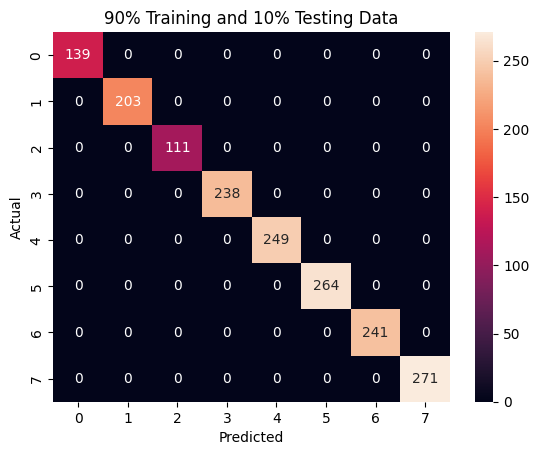

In [46]:
# 畫出confusion matrix
cm = confusion_matrix(y_all,y_prdict_all)
ax = sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual', title='90% Training and 10% Testing Data')
np.shape(y_all)

figure = ax.get_figure()
output_file = rootpath+'Result/Plot/all_confusion_matrix.jpg'
figure.savefig(output_file)

#初賽測試數據

##讀取並整理初賽測試數據

In [47]:
# 進入初賽訓練數據資料夾
os.chdir(rootpath+'thubigdata2019exam-722')

# 秀出當前路徑內檔案，確認是否在正確的路徑下
files = [f for f in os.listdir('.') if os.path.isfile(f)]

print(files)
print('Number of files:',len(files))

['13.txt', '10.txt', '11.txt', '1.txt', '12.txt', '14.txt', '15.txt', '17.txt', '16.txt', '24.txt', '18.txt', '19.txt', '21.txt', '22.txt', '20.txt', '2.txt', '23.txt', '25.txt', '26.txt', '27.txt', '28.txt', '29.txt', '35.txt', '30.txt', '33.txt', '31.txt', '34.txt', '3.txt', '32.txt', '36.txt', '4.txt', '6.txt', '7.txt', '9.txt', '5.txt', '8.txt']
Number of files: 36


In [49]:
# 利用迴圈將所有資料夾內檔案整合成一個dataframe
init_cnt = 0
os.chdir(rootpath+'thubigdata2019exam-722')

for i in files:
  data_tmp = pd.read_csv(i, sep='\\t', engine='python', index_col=False)
  data_tmp = data_tmp.transpose()
  data_tmp = data_tmp.drop([0],axis=1) #丟掉溫度單位(Deg.F)
  data_tmp = data_tmp.astype(float) #將string轉換成float

  data_tmp.insert(0,'Type',np.nan)
  data_tmp.insert(0,'FileName',i)

  if init_cnt == 0:
    data_test = data_tmp
    init_cnt += 1
  else:
    # Use pd.concat instead of append
    data_test = pd.concat([data_test, data_tmp], ignore_index=True, sort=False)

data_test = data_test.reset_index()
data_test = data_test.rename(columns={"index":"Col"})

# 加長時間長度和訓練一樣
for i in range(data_test.shape[1]-3,data.shape[1]-2):
  data_test[i] = np.nan

print(data_test.head())
print(data_test.shape)

   Col FileName  Type     1     2     3     4     5     6     7  ...  440  \
0    0   13.txt   NaN  71.3  71.3  71.3  71.3  71.9  72.7  73.7  ...  NaN   
1    1   13.txt   NaN  70.6  70.6  70.6  70.6  70.9  71.3  71.7  ...  NaN   
2    2   13.txt   NaN  71.9  71.9  71.9  71.9  72.4  73.0  73.9  ...  NaN   
3    3   13.txt   NaN  73.1  73.1  73.1  73.1  73.3  73.5  73.8  ...  NaN   
4    4   13.txt   NaN  68.5  68.5  68.5  68.5  68.8  69.6  69.7  ...  NaN   

   441  442  443  444  445  446  447  448  449  
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 452 columns]
(276, 452)


##初賽測試數據的設置分配與前處理

###對時間溫度曲線數據進行微分

In [50]:
m, n = data_test.shape
x_tmp1 = data_test.iloc[:,3:n].values.copy()
x_tmp2 = data_test.iloc[:,3:n].values.copy()
data_test_diff = data_test.copy()

for i in range(0,m):
  f = x_tmp1[i,0:n]

  ind = np.isnan(f)
  f[np.isnan(f)] = f[f.shape[0]-ind.sum()-1]

  fg = np.gradient(f)

  x_tmp1[i,0:n] = f
  x_tmp2[i,0:n] = fg

data_test.iloc[:,3:n] = x_tmp1
data_test_diff.iloc[:,3:n] = x_tmp2

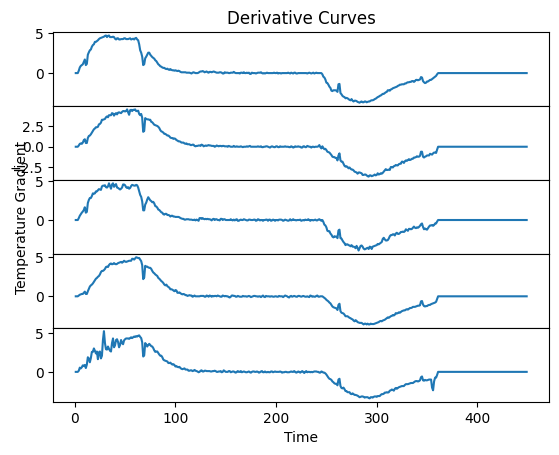

In [51]:
# 畫出test前5個微分的時間溫度曲線
subplots_adjust(hspace=0.000)
number_of_subplots=5

for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = subplot(number_of_subplots,1,v)
    ax1.plot(data_test_diff.iloc[i,3:n])

    if i == 0:
      plt.title('Derivative Curves')
    elif i == round(number_of_subplots/2):
      plt.ylabel('Temperature Gradient')
    elif i == number_of_subplots-1:
      plt.xlabel('Time')

plt.show()

figure=ax1.get_figure()
output_file = rootpath+'Result/Plot/derivative_curves_test.jpg'
figure.savefig(output_file)

###檢查是否有不穩定的時間溫度曲線

In [52]:
# 對微分數值設閾值，篩選不穩定之時間溫度曲線
ind_bad_test = []
m, n = data_test_diff.shape

for i in range(0,m):
  tmp = data_test_diff.iloc[i,3:n].values.copy()

  if abs(tmp.min())>15 or abs(tmp.max())>15:
    ind_bad_test = ind_bad_test + [i]

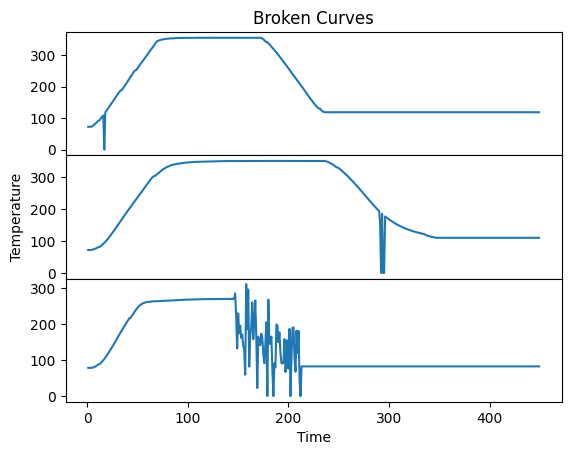

In [53]:
# 畫出壞掉的時間溫度曲線
subplots_adjust(hspace=0.000)
number_of_subplots=len(ind_bad_test)

for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = subplot(number_of_subplots,1,v)
    ax1.plot(data_test.iloc[ind_bad_test[i],3:data_test.shape[1]])

    if i == 0:
      plt.title('Broken Curves')
    elif i == round(number_of_subplots/2)-1:
      plt.ylabel('Temperature')
    elif i == number_of_subplots-1:
      plt.xlabel('Time')

plt.show()

figure=ax1.get_figure()
output_file = rootpath+'Result/Plot/broken_curves_true_test.jpg'
figure.savefig(output_file)

###設置初賽測試數據格式

In [54]:
# 設置x和y
x_true_test = data_test_diff.drop(['Col','FileName','Type'],axis=1)

# 將y做成one-hot encoding
# 要注意不同模型訓練的時候丟入的y有可能是原本0和1(y_train)，或是經過one-hot encoding的(y_dummy)
y_true_test = data_test_diff['Type']
y_dummy_true_test = pd.get_dummies(y_true_test)

In [55]:
# 檢視設置結果
print('true test:')
print('x:',x_true_test.shape)
print(x_true_test.head(3))
print('y:',y_dummy_true_test.shape)
print(y_dummy_true_test.head(3))

true test:
x: (276, 449)
   1    2    3     4     5     6     7    8    9     10   ...  440  441  442  \
0  0.0  0.0  0.0  0.30  0.70  0.90  1.00  1.1  1.4  1.70  ...  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.15  0.35  0.40  0.35  0.5  0.8  0.90  ...  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.25  0.55  0.75  0.95  1.1  1.3  1.65  ...  0.0  0.0  0.0   

   443  444  445  446  447  448  449  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 449 columns]
y: (276, 0)
Empty DataFrame
Columns: []
Index: [0, 1, 2]


##已訓練模型讀取與結果預測

In [56]:
# 進入儲存模型資料夾
os.chdir(rootpath+'Result/Model')
model.load_weights('model_fin.h5') #讀取模型

In [58]:
# 預測測試數據結果
y_probs_true_test = model.predict(x_true_test)
print(y_probs_true_test.shape) #矩陣大小
print(y_probs_true_test[0:4,:]) #只顯示前五列

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
(276, 8)
[[1.0596052e-02 9.0055003e-08 8.4289514e-10 8.2173369e-20 9.8940384e-01
  5.1893566e-27 1.5095961e-19 3.6188802e-16]
 [4.9145933e-02 2.5655374e-12 2.2162018e-07 1.2736950e-29 9.5085388e-01
  1.0835344e-22 1.3306382e-12 1.5415504e-10]
 [1.0252511e-02 4.2385562e-09 7.8022749e-10 6.7044323e-23 9.8974752e-01
  9.9843351e-27 7.8985621e-19 1.9186044e-15]
 [1.2198551e-01 4.2623806e-14 2.4708035e-07 8.6029840e-34 8.7801427e-01
  3.1233106e-22 8.4263100e-12 3.6955599e-09]]


In [59]:
# 數字轉換分類結果
ind = np.argmax(y_probs_true_test,1)
y_prdict_true_test = data_fin.Type.astype('category')
y_prdict_true_test = y_prdict_true_test.dtypes.categories
y_prdict_true_test = y_prdict_true_test[ind]
y_prdict_true_test = pd.Series(y_prdict_true_test)

# 將預測結果填入
data_test['Type'] = y_prdict_true_test

##預測結果輸出

###最後結果輸出

In [62]:
# 檔名重複的index
du_index = data_test['FileName'].duplicated()

# 每個檔案的開頭與結尾index
tmp_index = data_test.index[~du_index].tolist()
file_index = []
file_name = []

for i in range(0,len(tmp_index)-1):
  file_index = file_index+[[tmp_index[i],tmp_index[i+1]]]
  file_name = file_name+[data_test['FileName'][tmp_index[i]]]

file_index = file_index+[[tmp_index[i+1],data_test.shape[0]]]
file_name = file_name+[data_test['FileName'][tmp_index[i+1]]]

print(file_index)
print(file_name)

[[0, 8], [8, 16], [16, 24], [24, 29], [29, 37], [37, 45], [45, 53], [53, 61], [61, 69], [69, 77], [77, 85], [85, 93], [93, 101], [101, 109], [109, 117], [117, 122], [122, 130], [130, 138], [138, 146], [146, 154], [154, 162], [162, 170], [170, 178], [178, 186], [186, 194], [194, 202], [202, 210], [210, 218], [218, 226], [226, 234], [234, 240], [240, 248], [248, 254], [254, 262], [262, 268], [268, 276]]
['13.txt', '10.txt', '11.txt', '1.txt', '12.txt', '14.txt', '15.txt', '17.txt', '16.txt', '24.txt', '18.txt', '19.txt', '21.txt', '22.txt', '20.txt', '2.txt', '23.txt', '25.txt', '26.txt', '27.txt', '28.txt', '29.txt', '35.txt', '30.txt', '33.txt', '31.txt', '34.txt', '3.txt', '32.txt', '36.txt', '4.txt', '6.txt', '7.txt', '9.txt', '5.txt', '8.txt']


In [63]:
# 統計每個檔案分類的結果
file_name_int = []
file_cat = []
file_with_diff_cat = []

for i in range(0,len(file_name)):

  # 轉換檔名成整數
  (name,ext) = os.path.splitext(file_name[i])
  file_name_int = file_name_int+[int(name)]

  # 統計分類結果
  tmp = data_test['Type'][list(range(file_index[i][0],file_index[i][1]))]
  tmp = tmp.astype('category')
  cat_tmp = tmp.value_counts()
  cat_tmp = cat_tmp.index[0]
  file_cat = file_cat+[cat_tmp]

  if len(tmp.dtypes.categories)!=1:
    file_with_diff_cat = file_with_diff_cat+[i]

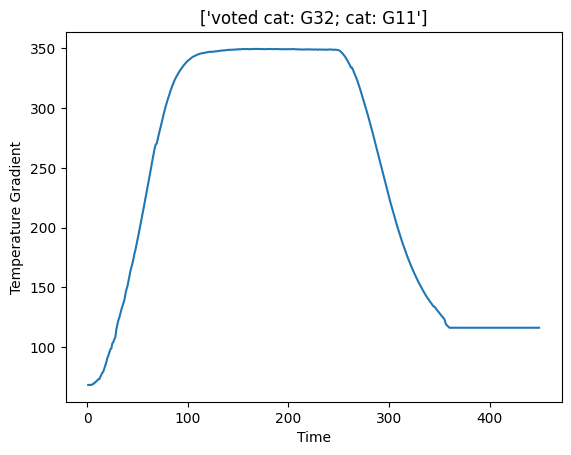

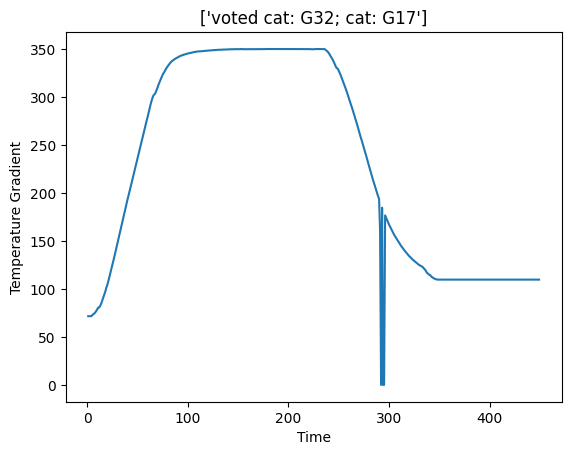

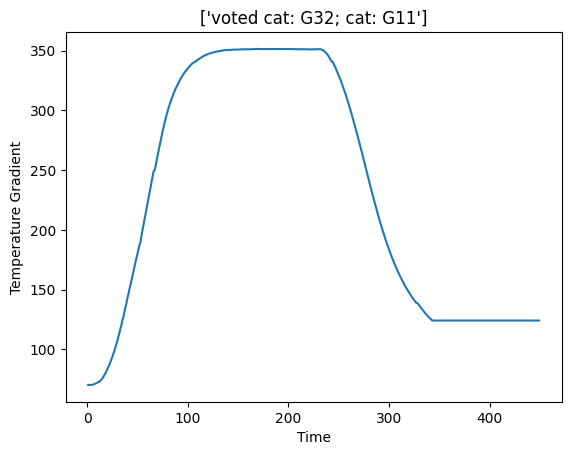

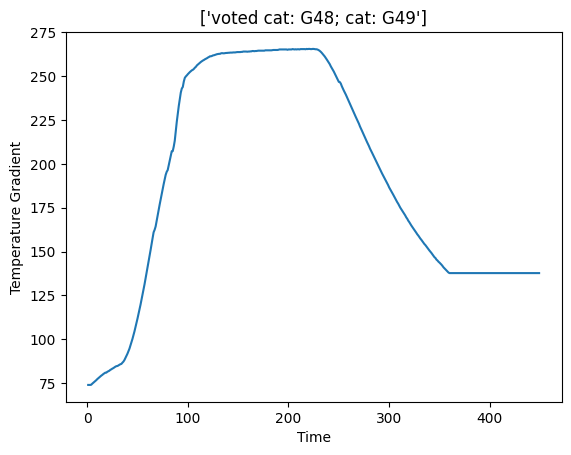

In [64]:
# 畫出檔案中分類不同的曲線

for i in file_with_diff_cat:
  tmp = data_test['Type'][list(range(file_index[i][0],file_index[i][1]))]
  tmp2 = data_test['FileName'][list(range(file_index[i][0],file_index[i][1]))]

  tmp = tmp.astype('category')
  cat_tmp = tmp.value_counts()
  cat_tmp1 = cat_tmp.index[0]

  for j in range(1,len(cat_tmp)):
    cat_tmp2 = cat_tmp.index[j]

    # 畫出檔案中分類不同的曲線

    plt.plot(data_test.iloc[tmp[tmp==cat_tmp2].index[0],3:data_test.shape[1]])
    plt.title(['voted cat: '+cat_tmp1+'; cat: '+cat_tmp2])
    plt.xlabel('Time')
    plt.ylabel('Temperature Gradient')

    str_1 = str(tmp[tmp==cat_tmp2].index[0])
    output_file = rootpath+'Result/Test_Wrong_Cat/test_' + str_1 + '.jpg'
    plt.savefig(output_file)

    plt.figure
    plt.show()

In [65]:
# 輸出比賽格式結果

# 將完整的測驗數據DataFrame輸出
os.chdir(rootpath+'Result/Test_Prediction')
data_test.to_excel('TestResult_all.xlsx', index = None, header=True)

# 檔名排序
files_sort_ind = sorted(range(len(file_name_int)), key=lambda k: file_name_int[k])

# 結果DataFrame
data_test_res = pd.DataFrame(list(range(1,len(files_sort_ind)+1)))
data_test_res[1] = [file_cat[i] for i in files_sort_ind]
data_test_res.columns = ['測驗數據資料代號','分類結果']

# 輸出成excel的xlsx格式
os.chdir(rootpath+'Result/Test_Prediction')
data_test_res.to_excel('2_108059_TestResult.xlsx', index = None, header=True)